In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [53]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\J.Zhao\AppData\Local\Temp\ipykernel_33076\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [55]:
base = automap_base()
base.prepare(autoload_with = engine)

In [56]:
# View all of the classes that automap found
print("Classes found by automap_base:")
for table_name, table_class in Base.classes.items():
    print(f"{table_name}: {table_class}")

Classes found by automap_base:
measurement: <class 'sqlalchemy.ext.automap.measurement'>
station: <class 'sqlalchemy.ext.automap.station'>


In [57]:

base.classes.keys()

['measurement', 'station']

In [58]:
# Save references to each table
table_references = {}
for table_name, table_class in Base.classes.items():
    table_references[table_name] = table_class



In [59]:
Measurement = base.classes.measurement
Station = base.classes.station

In [60]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [61]:
# Find the most recent date in the data set.

date_list = session.query(Measurement.date)
recent_date = [x[0] for x in date_list]
most_recent_date = max(recent_date)


print("The most recent date in the data set:", most_recent_date)

The most recent date in the data set: 2017-08-23


In [62]:
# Save references to each table
table_references = {}
for table_name, table_class in Base.classes.items():
    table_references[table_name] = table_class

In [63]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date_obj = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')


C:\Users\J.Zhao\AppData\Local\Temp\ipykernel_33076\1124680972.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\J.Zhao\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


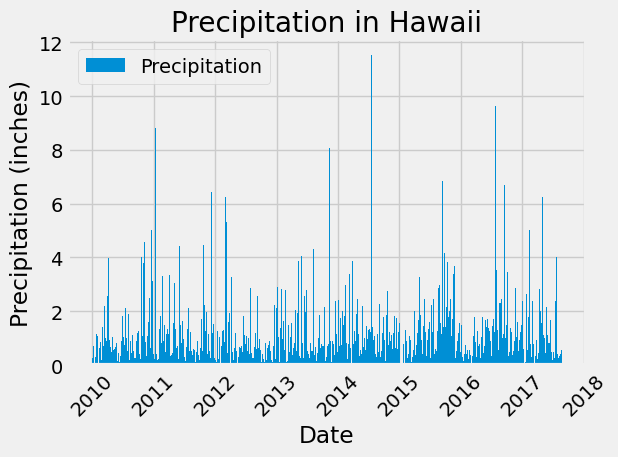

In [64]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_after = most_recent_date_obj + dt.timedelta(days=365)

#Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).all()

            # Close the session to release resources
session.close()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

            # Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'])


# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
#plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], width=5, align='center', label='Precipitation')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in Hawaii')
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
# Use Pandas to calculate the summary statistics for the precipitation data

    #Read
df = pd.read_sql_table('measurement', engine)

    #Calculate summary
summary_stats = df['prcp'].describe()

print(summary_stats)

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [68]:
# Design a query to calculate the total number of stations in the dataset
number_stations = session.query(Station.station).count()
print("Total number of stations:", number_stations)

Total number of stations: 9


In [69]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Station.station, func.count(Measurement.station)) \
                         .join(Measurement, Station.station == Measurement.station) \
                         .group_by(Station.station) \
                         .order_by(func.count(Measurement.station).desc()) \
                         .all()

print("Most active stations (in descending order):")
for station, count in active_stations:
    print(f"{station}: {count}")

Most active stations (in descending order):
USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [70]:
most_active_station_id = session.query(Station.station) \
                                .join(Measurement, Station.station == Measurement.station) \
                                .group_by(Station.station) \
                                .order_by(func.count(Measurement.station).desc()) \
                                .first()[0]

In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)) \
                           .filter(Measurement.station == most_active_station_id) \
                           .all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Most active station ({most_active_station_id}) temperature statistics:")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most active station (USC00519281) temperature statistics:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [74]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
temperature_data = session.query(Measurement.date, Measurement.tobs) \
                          .filter(Measurement.station == most_active_station_id) \
                          .filter(Measurement.date >= one_year_ago) \
                          .all()



In [77]:
df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])
df['Date'] = pd.to_datetime(df['Date'])

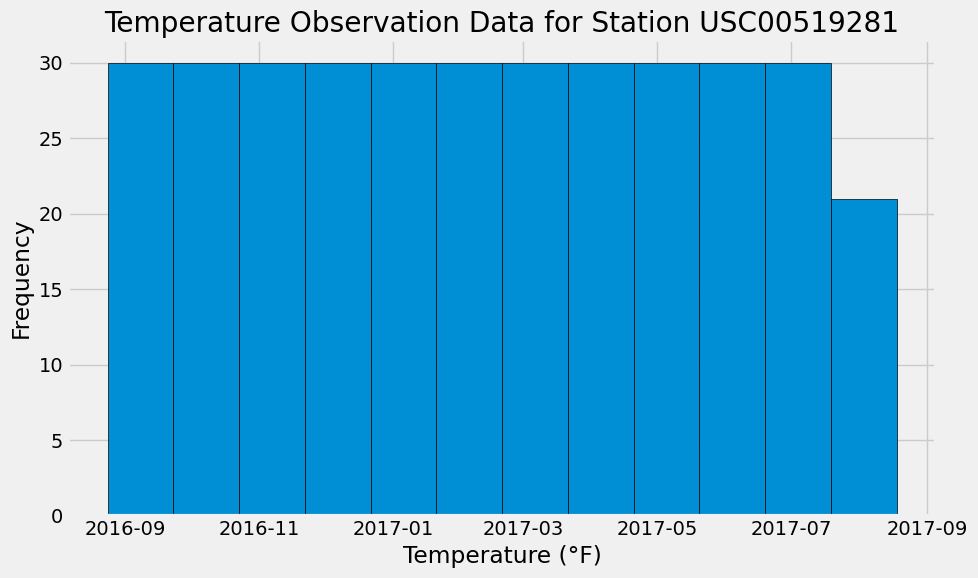

In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Date'], bins=12, edgecolor='k')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station_id}')
plt.tight_layout()
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()